In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import kagglehub
import os
import warnings
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import seaborn as sns
import requests
from pathlib import Path

In [74]:
warnings.filterwarnings("ignore")

## Load Dataset

In [75]:
path = kagglehub.dataset_download("fedesoriano/cirrhosis-prediction-dataset")

path

'/root/.cache/kagglehub/datasets/fedesoriano/cirrhosis-prediction-dataset/versions/2'

In [76]:
os.listdir(path)[0]

'cirrhosis.csv'

## Data PreProcessing

In [77]:
df = pd.read_csv(f'{path}/{os.listdir(path)[0]}')

df.head()

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [78]:
# check for missing values

def missing_values(df):
  missing_values = df[df.columns[1:]].isnull()
  return missing_values.sum(), len(df.columns)

missing_values(df)

(N_Days             0
 Status             0
 Drug             106
 Age                0
 Sex                0
 Ascites          106
 Hepatomegaly     106
 Spiders          106
 Edema              0
 Bilirubin          0
 Cholesterol      134
 Albumin            0
 Copper           108
 Alk_Phos         106
 SGOT             106
 Tryglicerides    136
 Platelets         11
 Prothrombin        2
 Stage              6
 dtype: int64,
 20)

In [79]:
# drop columns with missing values more than threshold

threshold = 0.8 * len(df)

df = df.dropna(thresh = threshold, axis = 1)

df.head()

,ID,N_Days,Status,Age,Sex,Edema,Bilirubin,Albumin,Platelets,Prothrombin,Stage
0,1,400,D,21464,F,Y,14.5,2.60,190.0,12.2,4.0
1,2,4500,C,20617,F,N,1.1,4.14,221.0,10.6,3.0
2,3,1012,D,25594,M,S,1.4,3.48,151.0,12.0,4.0
3,4,1925,D,19994,F,S,1.8,2.54,183.0,10.3,4.0
4,5,1504,CL,13918,F,N,3.4,3.53,136.0,10.9,3.0


In [80]:
missing_values(df)

(N_Days          0
 Status          0
 Age             0
 Sex             0
 Edema           0
 Bilirubin       0
 Albumin         0
 Platelets      11
 Prothrombin     2
 Stage           6
 dtype: int64,
 11)

In [81]:
# fill missing values

df['Platelets'] = df['Platelets'].fillna(df['Platelets'].median())
df['Prothrombin'] = df['Prothrombin'].fillna(df['Prothrombin'].mean())
df['Stage'] = df['Stage'].fillna(df['Stage'].median())

missing_values(df)

(N_Days         0
 Status         0
 Age            0
 Sex            0
 Edema          0
 Bilirubin      0
 Albumin        0
 Platelets      0
 Prothrombin    0
 Stage          0
 dtype: int64,
 11)

In [82]:
print(df['Sex'].unique())
print(df['Edema'].unique())
print(df['Status'].unique())

['F' 'M']
['Y' 'N' 'S']
['D' 'C' 'CL']


In [83]:
# converting str values in int

df['Sex'] = df['Sex'].map({'M': 0, 'F': 1})
df['Edema'] = df['Edema'].map({'N': 0, 'Y': 1, 'S': 0})
df['Status'] = df['Status'].map({'D': 0, 'C': 1, 'CL': 2})

df.head()

,ID,N_Days,Status,Age,Sex,Edema,Bilirubin,Albumin,Platelets,Prothrombin,Stage
0,1,400,0,21464,1,1,14.5,2.60,190.0,12.2,4.0
1,2,4500,1,20617,1,0,1.1,4.14,221.0,10.6,3.0
2,3,1012,0,25594,0,0,1.4,3.48,151.0,12.0,4.0
3,4,1925,0,19994,1,0,1.8,2.54,183.0,10.3,4.0
4,5,1504,2,13918,1,0,3.4,3.53,136.0,10.9,3.0


In [84]:
df = df.drop('ID', axis = 1)

df.head()

,N_Days,Status,Age,Sex,Edema,Bilirubin,Albumin,Platelets,Prothrombin,Stage
0,400,0,21464,1,1,14.5,2.60,190.0,12.2,4.0
1,4500,1,20617,1,0,1.1,4.14,221.0,10.6,3.0
2,1012,0,25594,0,0,1.4,3.48,151.0,12.0,4.0
3,1925,0,19994,1,0,1.8,2.54,183.0,10.3,4.0
4,1504,2,13918,1,0,3.4,3.53,136.0,10.9,3.0


In [85]:
print(f"We have to classify the data in {len(df['Stage'].unique())} classes ==> {df['Stage'].unique()}")

We have to classify the data in 4 classes ==> [4. 3. 2. 1.]


## Feature Selection

In [86]:
# correlation matrix
corr_matrix = df.corr()

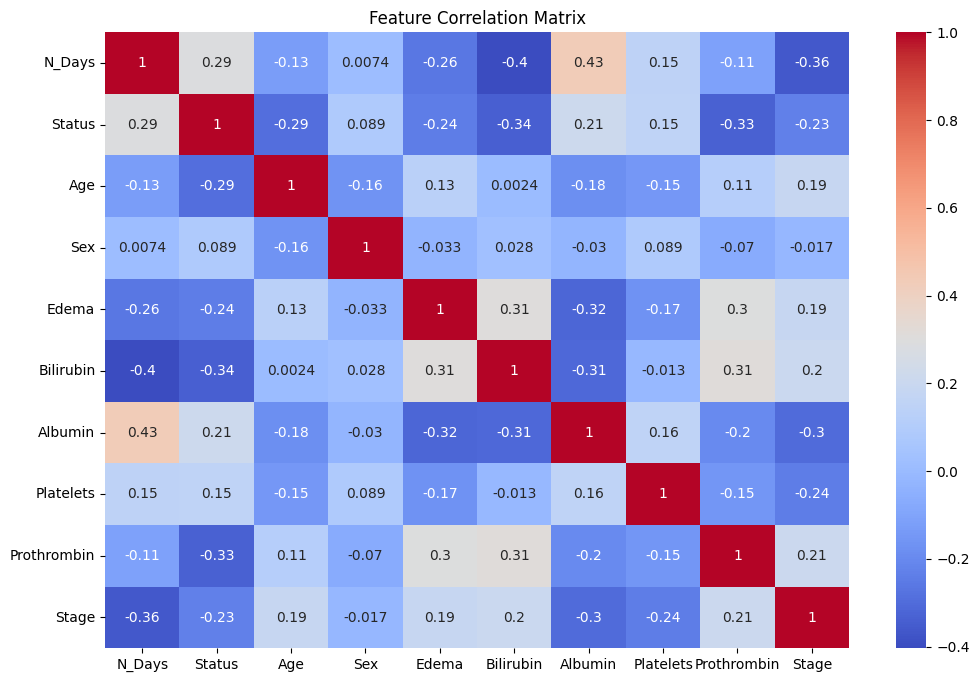

In [87]:
# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

In [88]:
# Select features with highly correlation to the target
correlation_threshold = 0.1
target = 'Stage'
relevant_features = corr_matrix[target][abs(corr_matrix[target]) > correlation_threshold].index

relevant_features

Index(['N_Days', 'Status', 'Age', 'Edema', 'Bilirubin', 'Albumin', 'Platelets',
       'Prothrombin', 'Stage'],
      dtype='object')

In [89]:
df_filtered = df[relevant_features]

## Data Scaling

In [90]:
# function to apply standard scaler
def standard_scaler(df):

  new_df = pd.DataFrame()

  for c in df.columns:
    if c == 'Stage':
      new_df[c] = df[c]
      continue
    mean = df[c].mean()
    std = df[c].std()
    new_df[c] = (df[c] - mean) / std

  return new_df

df = standard_scaler(df)

## Split and Convert Data

In [91]:
# split the data in test train
X = df.drop(['Stage'], axis=1)
y = df['Stage']

# y_train and y_test labels must start from 0
y = y - y.min()

In [92]:
# data available for each feature

count_stages = df['Stage'].value_counts()

count_stages

,count
Stage,
3.0,161
4.0,144
2.0,92
1.0,21


The data is imbalanced

## Scaling the Data

In [93]:
smote = SMOTE(random_state=42)

X_resampled, y_resampled = smote.fit_resample(X, y)

X_resampled.shape, y_resampled.shape

((644, 9), (644,))

In [94]:
X_resampled = pd.DataFrame(X_resampled, columns=X.columns)
y_resampled = pd.Series(y_resampled, name='Stage')

In [95]:
# data available for each feature

count_stages = y_resampled.value_counts()

count_stages

,count
Stage,
3.0,161
2.0,161
1.0,161
0.0,161


the data is balanced now

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

In [97]:
# convert data to tensors
X_train = torch.from_numpy(X_train.values).type(torch.float)
X_test = torch.from_numpy(X_test.values).type(torch.float)
y_train = torch.from_numpy(y_train.values).type(torch.LongTensor)
y_test = torch.from_numpy(y_test.values).type(torch.LongTensor)

In [98]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([515, 9]),
 torch.Size([129, 9]),
 torch.Size([515]),
 torch.Size([129]))

In [99]:
torch.unique(y_train)

tensor([0, 1, 2, 3])

## Creating the Neural Network

In [100]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [101]:
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [102]:
# accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct / len(y_pred)) * 100
  return acc

In [103]:
# define the model
class MyModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.Dropout(p=0.2),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

In [104]:
my_model = MyModel(input_features=X_train.shape[1], output_features= len(torch.unique(y_train)), hidden_units=26).to(device)
my_model

MyModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=9, out_features=26, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Linear(in_features=26, out_features=26, bias=True)
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Linear(in_features=26, out_features=4, bias=True)
  )
)

In [105]:
# loss function
loss_fn = nn.CrossEntropyLoss()

In [106]:
# optimizer
optimizer = torch.optim.SGD(params=my_model.parameters(), lr=0.01)

In [107]:
# Wrap the data into TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Create DataLoaders for mini-batches
batch_size = 6
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [108]:
epochs = 2000
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
epoch_list = []

for epoch in range(1, epochs + 1):
  my_model.train()
  train_loss, train_correct = 0, 0

  for X_batch, y_batch in train_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    y_logits = my_model(X_batch)
    loss = loss_fn(y_logits, y_batch)
    train_loss += loss.item()

    y_pred = torch.argmax(y_logits, dim=1)
    train_correct += (y_pred == y_batch).sum().item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_accuracy = 100 * train_correct / len(train_dataset)

  my_model.eval()
  test_loss, test_correct = 0, 0
  with torch.inference_mode():
    for X_batch, y_batch in test_loader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)

      test_logits = my_model(X_batch)
      test_loss += loss_fn(test_logits, y_batch).item()

      test_pred = torch.argmax(test_logits, dim=1)
      test_correct += (test_pred == y_batch).sum().item()

  test_accuracy = 100 * test_correct / len(test_dataset)

  if epoch % 10 == 0:
    epoch_list.append(epoch)
    train_loss_list.append(train_loss / len(train_loader))
    train_acc_list.append(train_accuracy)
    test_loss_list.append(test_loss / len(test_loader))
    test_acc_list.append(test_accuracy)

  if epoch % 20 == 0:
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Acc: {train_accuracy:.2f}% | "f"Test Loss: {test_loss:.5f} | Test Acc: {test_accuracy:.2f}%")

Epoch: 20 | Train Loss: 104.67199 | Train Acc: 41.55% | Test Loss: 26.16315 | Test Acc: 45.74%
Epoch: 40 | Train Loss: 100.48186 | Train Acc: 46.80% | Test Loss: 25.63520 | Test Acc: 48.06%
Epoch: 60 | Train Loss: 94.40928 | Train Acc: 50.68% | Test Loss: 25.09087 | Test Acc: 46.51%
Epoch: 80 | Train Loss: 90.83686 | Train Acc: 51.84% | Test Loss: 24.09424 | Test Acc: 49.61%
Epoch: 100 | Train Loss: 87.49309 | Train Acc: 54.37% | Test Loss: 23.08929 | Test Acc: 52.71%
Epoch: 120 | Train Loss: 80.55919 | Train Acc: 58.45% | Test Loss: 22.52753 | Test Acc: 55.04%
Epoch: 140 | Train Loss: 79.16283 | Train Acc: 61.36% | Test Loss: 21.70430 | Test Acc: 55.04%
Epoch: 160 | Train Loss: 76.52357 | Train Acc: 62.91% | Test Loss: 21.56823 | Test Acc: 59.69%
Epoch: 180 | Train Loss: 75.98842 | Train Acc: 60.97% | Test Loss: 21.25624 | Test Acc: 58.14%
Epoch: 200 | Train Loss: 76.54954 | Train Acc: 59.42% | Test Loss: 20.70567 | Test Acc: 61.24%
Epoch: 220 | Train Loss: 73.19360 | Train Acc: 63.11

## Conclusion: The Data is still overfitting on Train Data.

In [109]:
# Convert the recorded lists to numerical values if they are tensors
train_loss_list = [loss.item() if torch.is_tensor(loss) else loss for loss in train_loss_list]
test_loss_list = [loss.item() if torch.is_tensor(loss) else loss for loss in test_loss_list]

## Plot the Train vs Test data

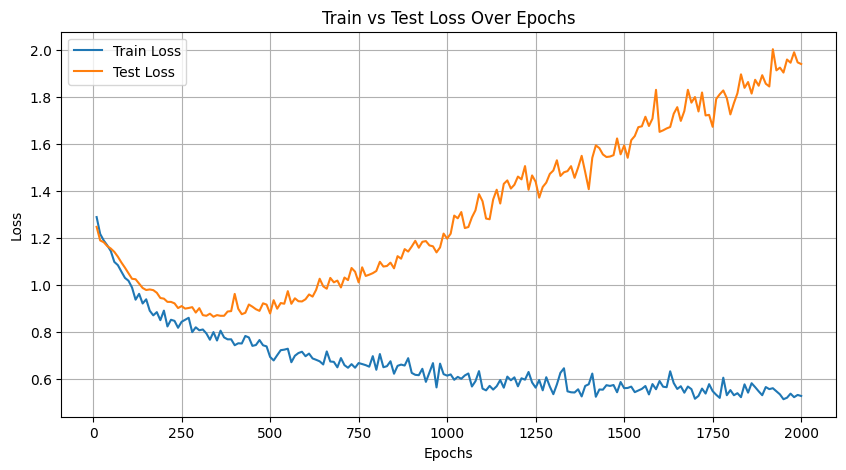

In [110]:
# Plot training vs test loss
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, train_loss_list, label="Train Loss", linestyle="-")
plt.plot(epoch_list, test_loss_list, label="Test Loss", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train vs Test Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

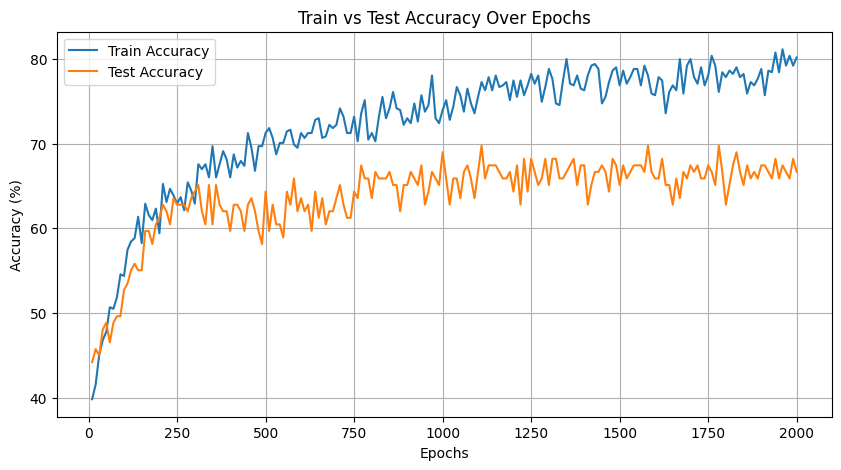

In [111]:
# Plot training vs test accuracy
plt.figure(figsize=(10, 5))
plt.plot(epoch_list, train_acc_list, label="Train Accuracy", linestyle="-")
plt.plot(epoch_list, test_acc_list, label="Test Accuracy", linestyle="-")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Test Accuracy Over Epochs")
plt.legend()
plt.grid()
plt.show()